In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# Set the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Set the path to your dataset
dataset_dir = ""

# Set the input size for resizing the images
input_size = (128,128)

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])


In [4]:
# Load the training dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the test dataset
test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Load the pre-trained GoogLeNet model
model = googlenet(pretrained=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

# # Training loop
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     train_correct = 0

#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         train_correct += (predicted == labels).sum().item()

#         loss = criterion(outputs, labels)
#         train_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     train_accuracy = train_correct / len(train_dataset)
#     train_loss /= len(train_loader)

#     # Evaluation on the test set
#     model.eval()
#     test_correct = 0

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             test_correct += (predicted == labels).sum().item()

#     test_accuracy = test_correct / len(test_dataset)

#     print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f}")


In [7]:
# Uncomment below lines to save model
# # Path for the saved model
path = './models/gnet.pt'
# Comment out below line if you have already saved model and just want to retrieve it (not saving)
# torch.save(model.state_dict(), path)

In [8]:
# Calculate the final accuracy on the entire test dataset
model.load_state_dict(torch.load(path))
model.eval()
test_correct = 0

preds_tensor = torch.Tensor()
labels_tensor = torch.Tensor()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds_tensor = torch.cat((preds_tensor, predicted))
        labels_tensor = torch.cat((labels_tensor, labels))
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = test_correct / len(test_dataset)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


Final Test Accuracy: 0.9770


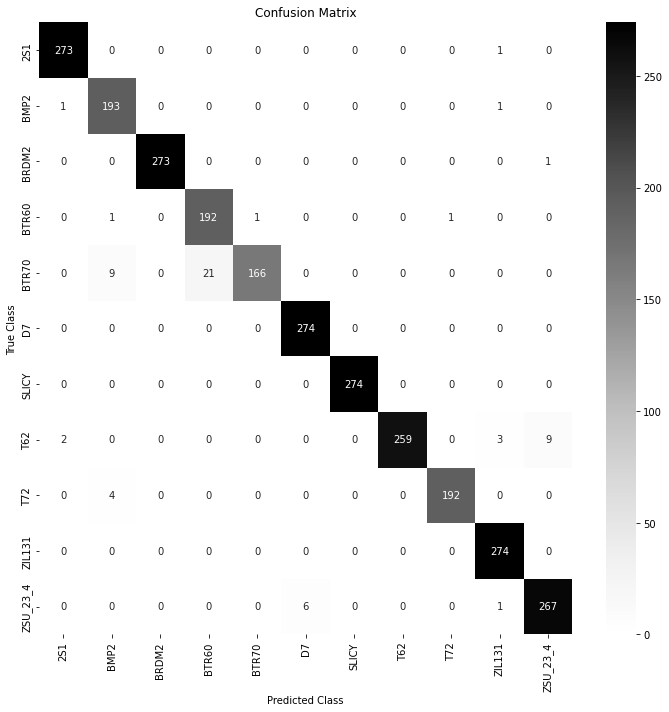

In [9]:
preds = preds_tensor.numpy()
actual = labels_tensor.numpy()

# Define the mapping dictionary
class_mapping = {
    0: '2S1',
    1: 'BMP2',
    2: 'BRDM2',
    3: 'BTR60',
    4: 'BTR70',
    5: 'D7',
    6: 'SLICY',
    7: 'T62',
    8: 'T72',
    9: 'ZIL131',
    10: 'ZSU_23_4'
}

y_preds = np.array([class_mapping[value] for value in preds])
y_true = np.array([class_mapping[value] for value in actual])

class_labels = ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70',
                'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_preds, labels=class_labels)

# Set figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Configure figure properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()

# Show the figure
plt.show()


In [10]:
from sklearn.metrics import classification_report

classification_report(y_true, y_preds, labels=class_labels, output_dict=True)

{'2S1': {'precision': 0.9891304347826086,
  'recall': 0.9963503649635036,
  'f1-score': 0.9927272727272726,
  'support': 274},
 'BMP2': {'precision': 0.9323671497584541,
  'recall': 0.9897435897435898,
  'f1-score': 0.9601990049751243,
  'support': 195},
 'BRDM2': {'precision': 1.0,
  'recall': 0.9963503649635036,
  'f1-score': 0.9981718464351006,
  'support': 274},
 'BTR60': {'precision': 0.9014084507042254,
  'recall': 0.9846153846153847,
  'f1-score': 0.9411764705882353,
  'support': 195},
 'BTR70': {'precision': 0.9940119760479041,
  'recall': 0.8469387755102041,
  'f1-score': 0.9146005509641874,
  'support': 196},
 'D7': {'precision': 0.9785714285714285,
  'recall': 1.0,
  'f1-score': 0.9891696750902527,
  'support': 274},
 'SLICY': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 274},
 'T62': {'precision': 1.0,
  'recall': 0.9487179487179487,
  'f1-score': 0.9736842105263158,
  'support': 273},
 'T72': {'precision': 0.9948186528497409,
  'recall': 0.9795918367346939

In [11]:
matrix = confusion_matrix(y_true, y_preds, labels=class_labels)
class_wise_accuracies = matrix.diagonal()/matrix.sum(axis=1)

#Display the class-wise accuracies
for i, accuracy in enumerate(class_wise_accuracies):
    label = class_labels[i]
    print(f'Accuracy of class {label}: {accuracy:.2%}')


Accuracy of class 2S1: 99.64%
Accuracy of class BMP2: 98.97%
Accuracy of class BRDM2: 99.64%
Accuracy of class BTR60: 98.46%
Accuracy of class BTR70: 84.69%
Accuracy of class D7: 100.00%
Accuracy of class SLICY: 100.00%
Accuracy of class T62: 94.87%
Accuracy of class T72: 97.96%
Accuracy of class ZIL131: 100.00%
Accuracy of class ZSU_23_4: 97.45%
